In [2]:
import os
import ipynbname
import sys

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from pytorch_lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.strategies import DDPStrategy
from time import perf_counter
import wandb
import numpy as np

import torch
torch.set_float32_matmul_precision('medium')

from src.algorithms.unrolling_policy_iteration import UnrollingPolicyIterationTrain
from src.environments import CliffWalkingEnv
from src.algorithms.generalized_policy_iteration import PolicyIterationTrain
from src.utils import get_optimal_q, test_pol_err, plot_errors, save_error_matrix_to_csv

SAVE = True
PATH = "results/n_unrolls/"

## Auxiliary functions

In [7]:
def run(g, N_unrolls, Exps, q_opt, group_name, use_logger=True, log_every_n_steps=1, verbose=False):
    err1 = np.zeros((len(Exps), N_unrolls.size))
    err2 = np.zeros((len(Exps), N_unrolls.size))
    bell_err = np.zeros((len(Exps), N_unrolls.size))
    
    use_logger = use_logger and g == 0

    for i, n_unrolls in enumerate(N_unrolls):
        n_unrolls = int(n_unrolls)
        for j, exp in enumerate(Exps):
            env = CliffWalkingEnv()

            if exp["model"] == "unroll":
                model = UnrollingPolicyIterationTrain(env=env, env_test=env, num_unrolls=n_unrolls, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}unrolls",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=3000, log_every_n_steps=log_every_n_steps, accelerator="cpu", logger=logger)

            elif exp["model"] == "pol-it":
                model = PolicyIterationTrain(env=env, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}impr",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=n_unrolls, log_every_n_steps=log_every_n_steps, accelerator='cpu', logger=logger)
            else:
                raise Exception("Unknown model")

            trainer.fit(model)
            wandb.finish()

            err1[j,i], err2[j,i] = test_pol_err(model.Pi, q_opt)
            bell_err[j,i] = model.bellman_error.cpu().numpy()

            if verbose:
                print(f"- {g}. Unrolls {n_unrolls}: Model: {exp['name']} Err1: {err1[j,i]:.3f} | bell_err: {bell_err[j,i]:.3f}")
    return err1, err2, bell_err


## K = 5

In [4]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 5
group_name = f"n_unrolls-K{K}"

N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
----------------------

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 173.16it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 170.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 107.61it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 15

errs1 = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs2 = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 249.32it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 73.73it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 8.222 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 238.56it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 72.51it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: pol-it-5eval Err1: 7.505 | bell_err: 0.017
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 114.12it/s, reward_smoothness=1.050, bellman_error=631.0, loss=2.07e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 71.38it/s, reward_smoothness=1.050, bellman_error=631.0, loss=2.07e+3] 
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 12     | train
1 | model_test | UnrolledPolicyIterationModel | 12     | train
--------------------------------------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-WS Err1: 12241.005 | bell_err: 1.043
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 136.68it/s, reward_smoothness=1.020, bellman_error=630.0, loss=2.07e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 74.89it/s, reward_smoothness=1.020, bellman_error=630.0, loss=2.07e+3] 
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5 Err1: 12242.327 | bell_err: 1.007
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 196.03it/s, bellman_error=0.0195, policy_diff=2.450, q_norm=645.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 73.45it/s, bellman_error=0.0195, policy_diff=2.450, q_norm=645.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 4: Model: val-it Err1: 7.710 | bell_err: 0.020
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 230.24it/s, bellman_error=0.0122, policy_diff=5.290, q_norm=767.0] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 78.63it/s, bellman_error=0.0122, policy_diff=5.290, q_norm=767.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: pol-it-5eval Err1: 6.517 | bell_err: 0.012
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 106.07it/s, reward_smoothness=0.981, bellman_error=525.0, loss=1.43e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 65.41it/s, reward_smoothness=0.981, bellman_error=525.0, loss=1.43e+3] 
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 24     | train
1 | model_test | UnrolledPolicyIterationModel | 24     | train
--------------------------------------------------------------------
48        Trainable params
0         Non-trainable params
48        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-WS Err1: 7.579 | bell_err: 0.830
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 86.33it/s, reward_smoothness=1.020, bellman_error=633.0, loss=2.09e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 54.31it/s, reward_smoothness=1.020, bellman_error=633.0, loss=2.09e+3]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5 Err1: 19182.914 | bell_err: 1.019
Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 229.18it/s, bellman_error=0.0174, policy_diff=2.450, q_norm=658.0]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 75.95it/s, bellman_error=0.0174, policy_diff=2.450, q_norm=658.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



- 0. Unrolls 6: Model: val-it Err1: 7.014 | bell_err: 0.017



  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 217.68it/s, bellman_error=0.00895, policy_diff=2.450, q_norm=819.0]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 74.48it/s, bellman_error=0.00895, policy_diff=2.450, q_norm=819.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: pol-it-5eval Err1: 5.842 | bell_err: 0.009
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s, reward_smoothness=0.983, bellman_error=551.0, loss=1.58e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 47.89it/s, reward_smoothness=0.983, bellman_error=551.0, loss=1.58e+3]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 36     | train
1 | model_test | UnrolledPolicyIterationModel | 36     | train
--------------------------------------------------------------------
72        Trainable params
0         Non-trainable params
72        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-WS Err1: 2057.070 | bell_err: 0.872
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 67.15it/s, reward_smoothness=1.090, bellman_error=642.0, loss=2.15e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 45.08it/s, reward_smoothness=1.090, bellman_error=642.0, loss=2.15e+3]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5 Err1: 13495.346 | bell_err: 1.160
Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 229.72it/s, bellman_error=0.0153, policy_diff=2.450, q_norm=672.0]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 76.66it/s, bellman_error=0.0153, policy_diff=2.450, q_norm=672.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False


- 0. Unrolls 8: Model: val-it Err1: 6.327 | bell_err: 0.015


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 212.25it/s, bellman_error=0.00675, policy_diff=2.450, q_norm=862.0]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 73.80it/s, bellman_error=0.00675, policy_diff=2.450, q_norm=862.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 8: Model: pol-it-5eval Err1: 5.173 | bell_err: 0.007



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 57.96it/s, reward_smoothness=0.986, bellman_error=571.0, loss=1.7e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 41.07it/s, reward_smoothness=0.986, bellman_error=571.0, loss=1.7e+3]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 48     | train
1 | model_test | UnrolledPolicyIterationModel | 48     | train
--------------------------------------------------------------------
96        Trainable params
0         Non-trainable params
96        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-WS Err1: 4.800 | bell_err: 0.904
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 54.82it/s, reward_smoothness=0.990, bellman_error=599.0, loss=1.87e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s, reward_smoothness=0.990, bellman_error=599.0, loss=1.87e+3]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5 Err1: 4.842 | bell_err: 0.925
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 226.57it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 66.92it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0] 
- 0. Unrolls 10: Model: val-it Err1: 5.651 | bell_err: 0.013


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 233.21it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 67.47it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0] 
- 0. Unrolls 10: Model: pol-it-5eval Err1: 2057.070 | bell_err: 0.005


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 50.36it/s, reward_smoothness=0.985, bellman_error=582.0, loss=1.76e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 36.80it/s, reward_smoothness=0.985, bellman_error=582.0, loss=1.76e+3]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 60     | train
1 | model_test | UnrolledPolicyIterationModel | 60     | train
--------------------------------------------------------------------
120       Trainable params
0         Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-WS Err1: 8.021 | bell_err: 0.908
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 47.86it/s, reward_smoothness=0.979, bellman_error=583.0, loss=1.77e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 34.58it/s, reward_smoothness=0.979, bellman_error=583.0, loss=1.77e+3]
P_pi is NOT diagonalizable
- 0. Unrolls 10: Model: unr-K5 Err1: 7.579 | bell_err: 0.892
----- Solved in 0.167 minutes -----


In [ ]:
# # Load data
# data = np.load(PATH + "n_unrolls-K5_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs1 = data["errs1"]
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

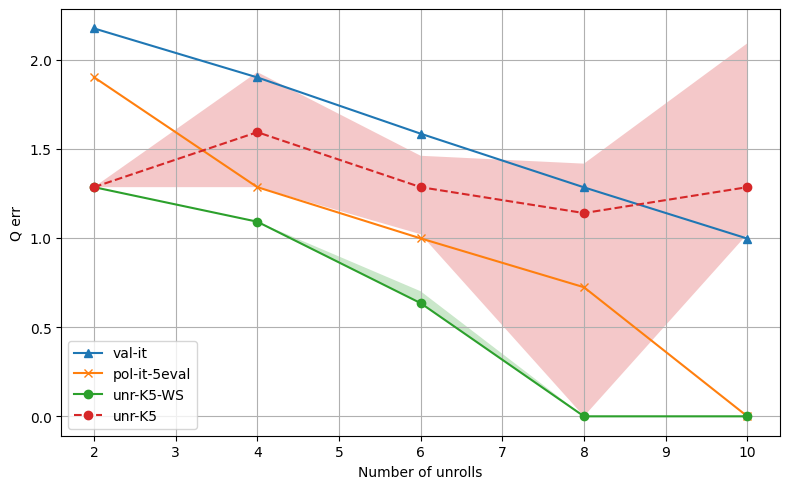

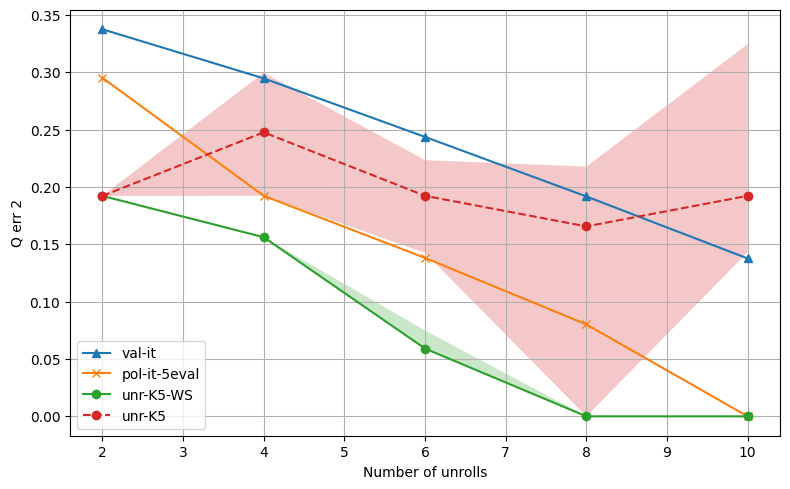

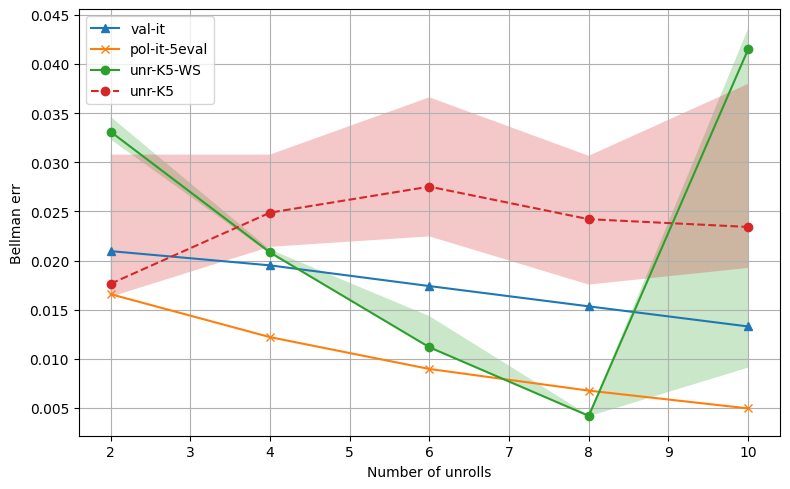

In [4]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=10

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
K = 10
group_name = f"n_unrolls-K{K}"
N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 15

errs1 = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs2 = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 234.20it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 196.91it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

- 0. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 2: Model: unr-K5-WS Err1: 1.285 | bell_err: 0.035
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K10-WS Err1: 2.217 | bell_err: 0.017
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.92it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 236.97it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 225.32it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 0. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 5: Model: unr-K5-WS Err1: 0.950 | bell_err: 0.019
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


- 0. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.013
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.006
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.72it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 2: Model: unr-K5-WS Err1: 1.909 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K10-WS Err1: 0.128 | bell_err: 0.016
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.91it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 239.77it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 237.56it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 5: Model: unr-K5-WS Err1: 0.813 | bell_err: 0.016
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 240.09it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 227.77it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 225.14it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 1. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.56it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.92it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 2. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1734:   0%|          | 0/1 [00:00<?, ?it/s, reward_smoothness=0.980, bellman_error=14.80, loss=1.150]         

In [ ]:
# # Load data
# data = np.load(PATH + "n_unrolls-K10_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs1 = data["errs1"]
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

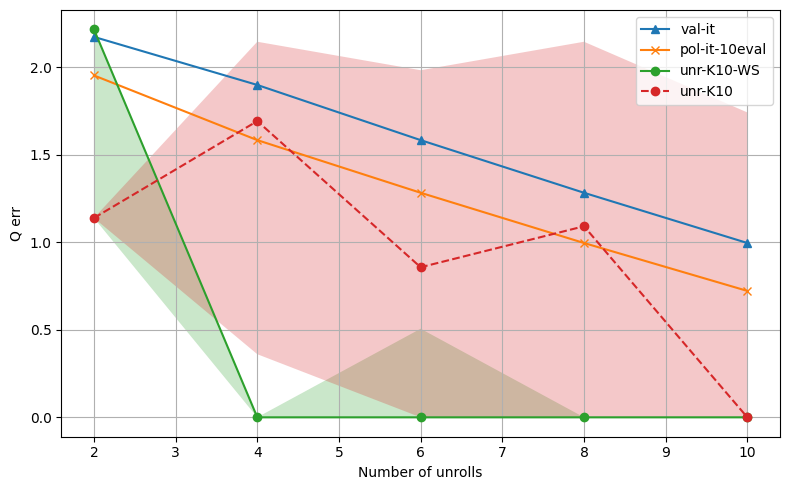

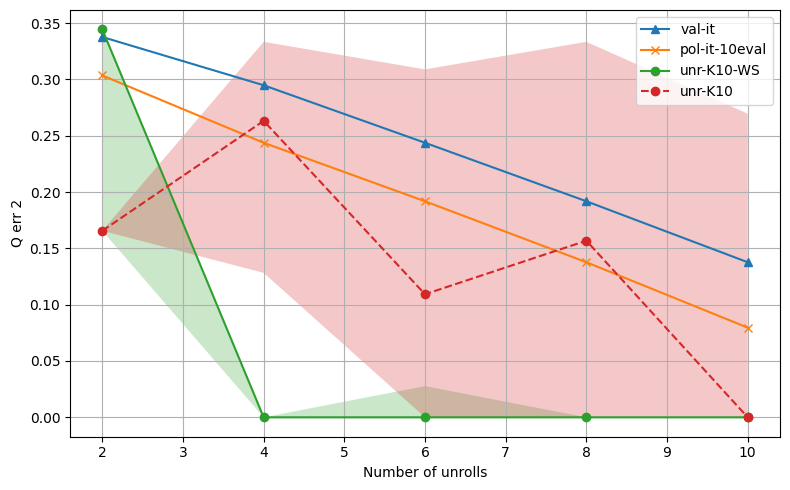

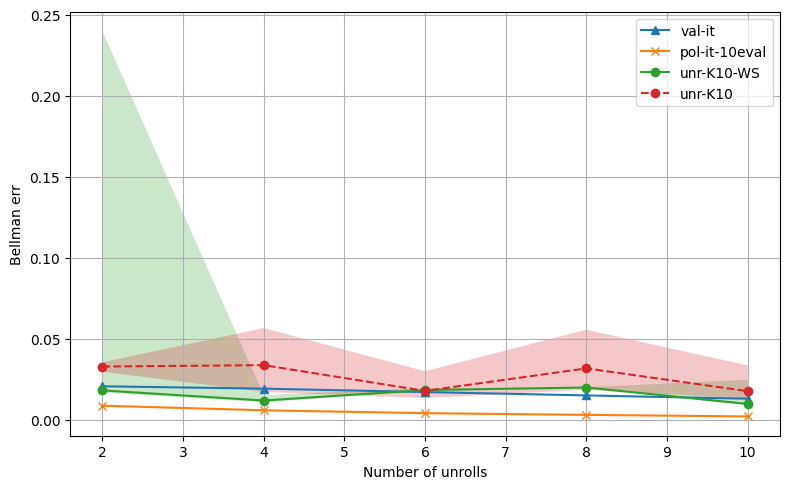

In [6]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=15

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 15
group_name = f"n_unrolls-K{K}"
N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 15

errs1 = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs2 = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 234.20it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 196.91it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

- 0. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 2: Model: unr-K5-WS Err1: 1.285 | bell_err: 0.035
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K10-WS Err1: 2.217 | bell_err: 0.017
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.92it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 236.97it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 225.32it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 0. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 5: Model: unr-K5-WS Err1: 0.950 | bell_err: 0.019
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


- 0. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.013
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.006
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.72it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 2: Model: unr-K5-WS Err1: 1.909 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K10-WS Err1: 0.128 | bell_err: 0.016
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.91it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 239.77it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 237.56it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 5: Model: unr-K5-WS Err1: 0.813 | bell_err: 0.016
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 240.09it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 227.77it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 225.14it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 1. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.56it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.92it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 2. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1734:   0%|          | 0/1 [00:00<?, ?it/s, reward_smoothness=0.980, bellman_error=14.80, loss=1.150]         

In [ ]:
# # Load data
# data = np.load(PATH + "n_unrolls-K15_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs1 = data["errs1"]
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

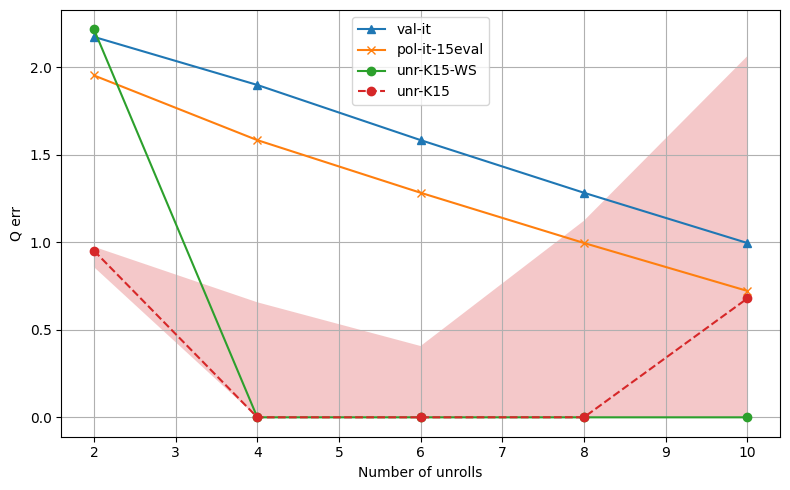

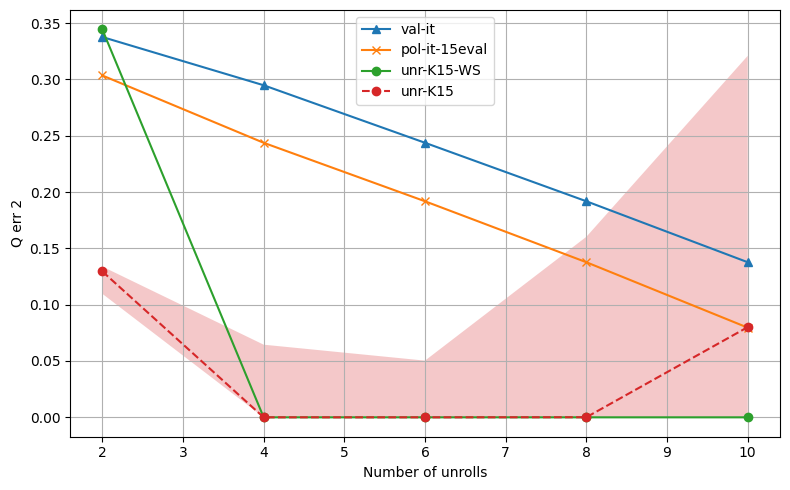

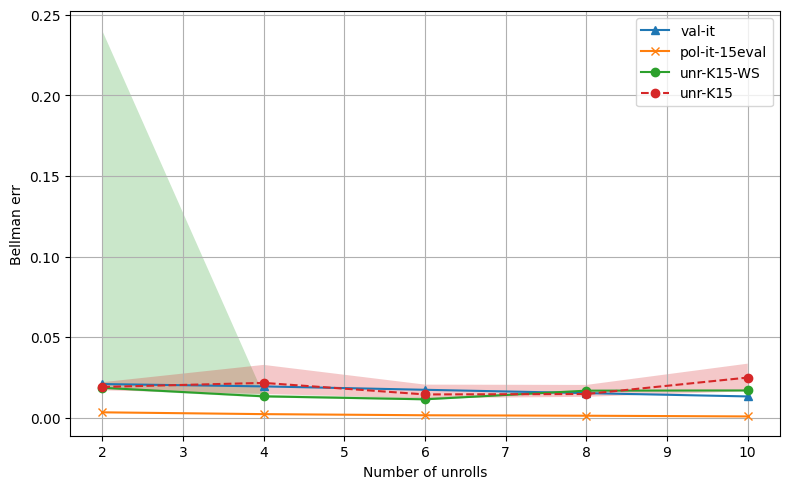

In [10]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Plot All

In [ ]:
# Load data
files = ["n_unrolls-K5_data.npz", "n_unrolls-K10_data.npz", "n_unrolls-K15_data.npz"]

Exps = []
errs1_list = []
errs2_list = []
bell_errs_list = []
for file in files:
    data = np.load(PATH + file, allow_pickle=True)
    
    if 'N_unrolls' not in locals():  # Save only once
        N_unrolls = data["N_unrolls"]
    
    Exps += list(data["Exps"])
    
    errs1_list.append(data["errs1"])
    errs2_list.append(data["errs2"])
    bell_errs_list.append(data["bell_errs"])

# Concatenate all data
errs1 = np.concatenate(errs1_list, axis=1)
errs2 = np.concatenate(errs2_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

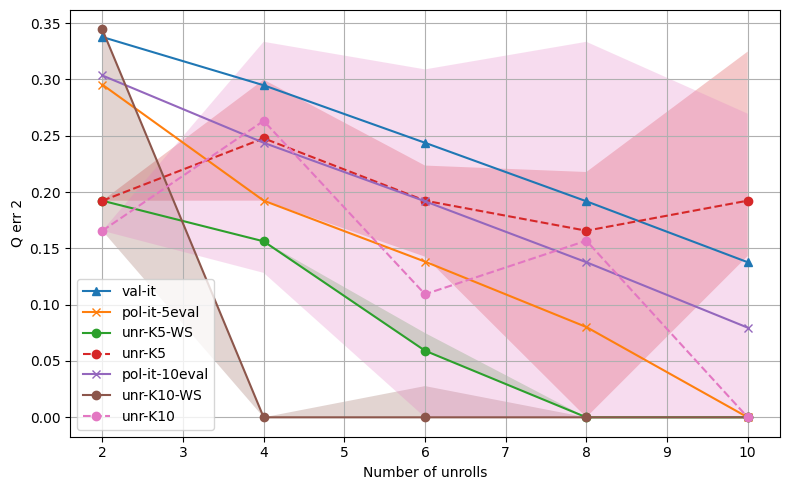

Data saved to csv file: results/n_unrolls/n_unrolls_all_data_med_err.csv
Data saved to csv file: results/n_unrolls/n_unrolls_all_data_prctile25.csv
Data saved to csv file: results/n_unrolls/n_unrolls_all_data_prctile75.csv


In [ ]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [4, 8, 9, 10, 11]
xlabel = "Number of unrolls"
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')

if SAVE:
    file_name = PATH + "n_unrolls_all_data_med_err.csv"
    save_error_matrix_to_csv(np.median(errs2, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "n_unrolls_all_data_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 25, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "n_unrolls_all_data_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 75, axis=0), N_unrolls, Exps, file_name)

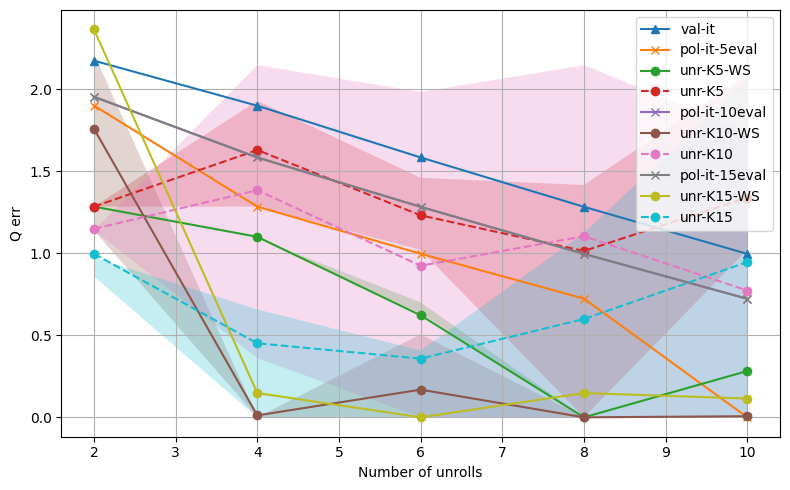

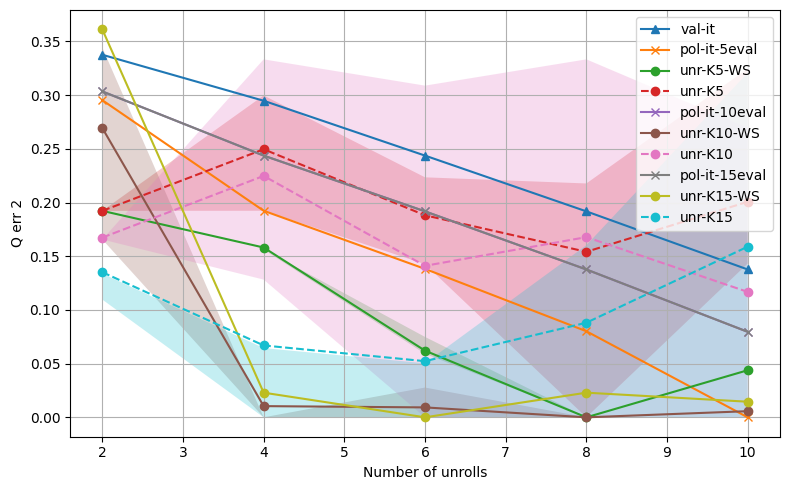

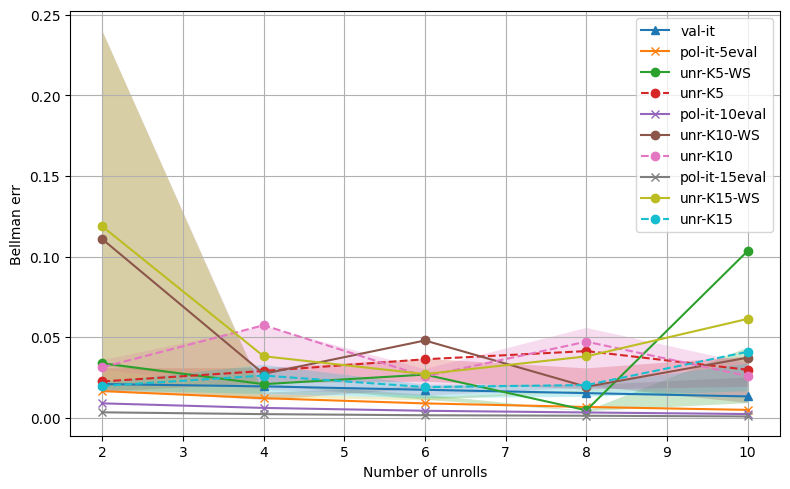

In [ ]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [4, 8]
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
# plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')

(12, 5)


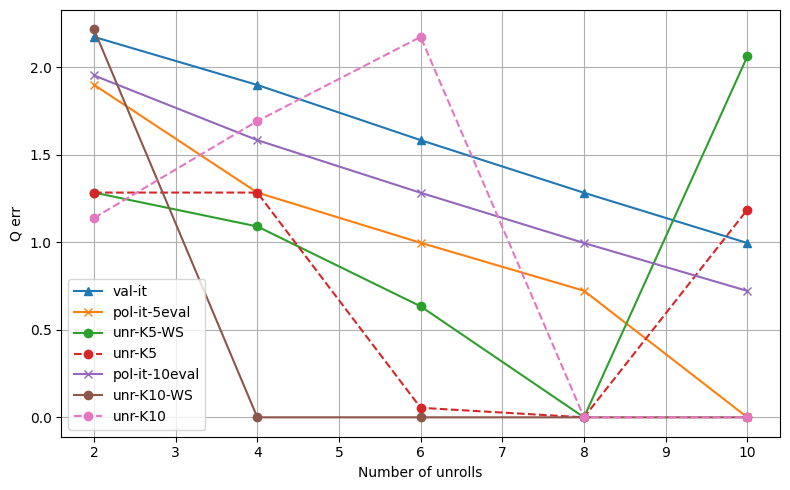

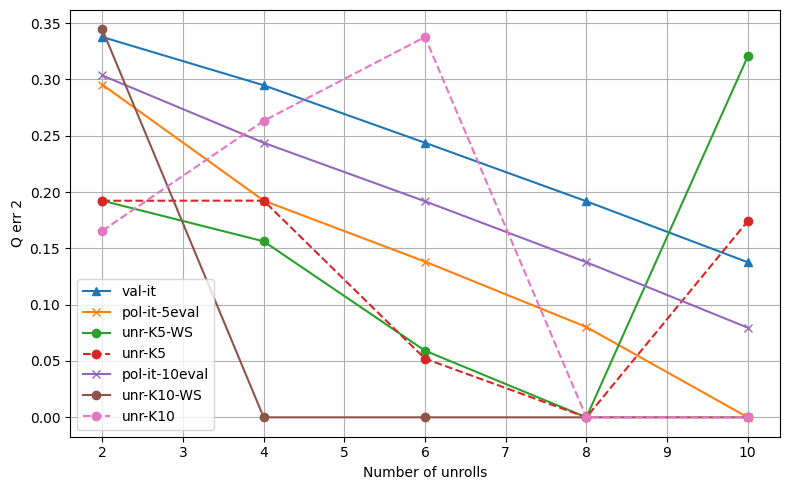

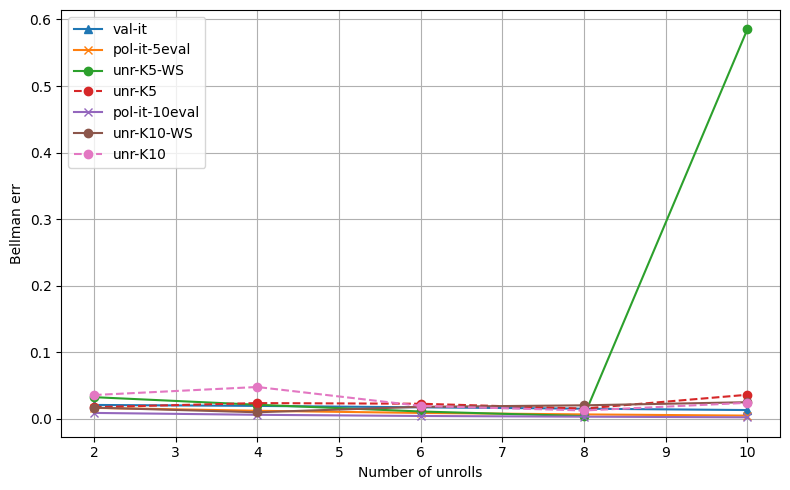

In [ ]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [4, 8, 9, 10, 11]
xlabel = "Number of unrolls"

plot_errors(errs1[0], N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg=None, deviation=None)
plot_errors(errs2[0], N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg=None, deviation=None)
plot_errors(bell_errs[0], N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg=None, deviation=None)

## New Loss Functions and Initializations

In [ ]:
# Run experiments with all combinations of loss functions and initializations
verbose = True
use_logger = False
log_every_n_steps = 1
K = 10
group_name = f"new_loss_init_K{K}"
N_unrolls = np.arange(2,11, 2)

# Define all combinations of loss functions and initializations
loss_types = ["original_with_detach", "original_no_detach", "max_with_detach", "max_no_detach"]
init_types = ["zeros", "random"]

# Create experiments for all combinations
Exps_new = []

# Add all combinations of loss functions and initializations  
for loss_type in loss_types:
    for init_type in init_types:
        exp_name = f"unr-K{K}-{loss_type}-{init_type}"
        Exps_new.append({
            "model": "unroll",
            "args": {
                "K": K, 
                "tau": 5, 
                "lr": 5e-3, 
                "weight_sharing": True,
                "loss_type": loss_type,
                "init_q": init_type
            },
            "fmt": "s-", 
            "name": exp_name
        })

print(f"Total experiments: {len(Exps_new)}")
for i, exp in enumerate(Exps_new):
    print(f"{i}: {exp['name']}")

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Total experiments: 8
0: unr-K5-original_with_detach-zeros
1: unr-K5-original_with_detach-random
2: unr-K5-original_no_detach-zeros
3: unr-K5-original_no_detach-random
4: unr-K5-max_with_detach-zeros
5: unr-K5-max_with_detach-random
6: unr-K5-max_no_detach-zeros
7: unr-K5-max_no_detach-random


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
# Run the new experiments
n_runs = 15

errs1_new = np.zeros((n_runs, len(Exps_new), N_unrolls.size))
errs2_new = np.zeros((n_runs, len(Exps_new), N_unrolls.size))
bell_errs_new = np.zeros((n_runs, len(Exps_new), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1_new[g], errs2_new[g], bell_errs_new[g] = run(g, N_unrolls, Exps_new, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- New experiments solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps_new, errs1=errs1_new, errs2=errs2_new, bell_errs=bell_errs_new)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-original_with_detach-zeros Err1: 1.285 | bell_err: 0.048


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-original_with_detach-random Err1: 1.385 | bell_err: 0.049


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-original_no_detach-zeros Err1: 1.285 | bell_err: 0.022


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-original_no_detach-random Err1: 1.385 | bell_err: 0.022


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-max_with_detach-zeros Err1: 1.285 | bell_err: 0.022


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-max_with_detach-random Err1: 2.217 | bell_err: 0.025


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-max_no_detach-zeros Err1: 1.285 | bell_err: 0.010


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K5-max_no_detach-random Err1: 0.998 | bell_err: 0.010


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-original_with_detach-zeros Err1: 1.091 | bell_err: 0.036


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-original_with_detach-random Err1: 1.091 | bell_err: 0.035


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-original_no_detach-zeros Err1: 1.139 | bell_err: 0.021


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-original_no_detach-random Err1: 1.139 | bell_err: 0.019


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-max_with_detach-zeros Err1: 1.139 | bell_err: 0.018


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-max_with_detach-random Err1: 2.217 | bell_err: 0.939


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-max_no_detach-zeros Err1: 1.139 | bell_err: 0.014


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 4: Model: unr-K5-max_no_detach-random Err1: 1.139 | bell_err: 0.012


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 0. Unrolls 6: Model: unr-K5-original_with_detach-zeros Err1: 0.634 | bell_err: 0.032


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-original_with_detach-random Err1: 0.591 | bell_err: 0.031


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-original_no_detach-zeros Err1: 2.425 | bell_err: 0.486


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-original_no_detach-random Err1: 0.859 | bell_err: 0.023


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-max_with_detach-zeros Err1: 0.813 | bell_err: 0.018


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-max_with_detach-random Err1: 0.000 | bell_err: 0.022


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-max_no_detach-zeros Err1: 0.813 | bell_err: 0.011


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 6: Model: unr-K5-max_no_detach-random Err1: 0.859 | bell_err: 0.012


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-original_with_detach-zeros Err1: 0.000 | bell_err: 0.027


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-original_with_detach-random Err1: 2.217 | bell_err: 0.136


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-original_no_detach-zeros Err1: 0.998 | bell_err: 0.270


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-original_no_detach-random Err1: 0.000 | bell_err: 0.024


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-max_with_detach-zeros Err1: 0.000 | bell_err: 0.016


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-max_with_detach-random Err1: 0.000 | bell_err: 0.017


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-max_no_detach-zeros Err1: 0.000 | bell_err: 0.012


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 8: Model: unr-K5-max_no_detach-random Err1: 0.000 | bell_err: 0.012


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-original_with_detach-zeros Err1: 0.000 | bell_err: 0.025


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-original_with_detach-random Err1: 0.000 | bell_err: 0.025


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-original_no_detach-zeros Err1: 0.000 | bell_err: 0.037


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-original_no_detach-random Err1: 0.000 | bell_err: 0.023


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-max_with_detach-zeros Err1: 0.000 | bell_err: 0.017


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-max_with_detach-random Err1: 0.000 | bell_err: 0.024


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-max_no_detach-zeros Err1: 0.000 | bell_err: 0.010


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K5-max_no_detach-random Err1: 0.000 | bell_err: 0.010


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K5-original_with_detach-zeros Err1: 1.285 | bell_err: 0.048


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K5-original_with_detach-random Err1: 1.091 | bell_err: 0.051


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K5-original_no_detach-zeros Err1: 16060.370 | bell_err: 0.857


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-original_with_detach-zeros Err1: 0.591 | bell_err: 0.031


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-original_with_detach-random Err1: 0.724 | bell_err: 0.032


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-original_no_detach-zeros Err1: 0.813 | bell_err: 0.022


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-original_no_detach-random Err1: 12089.025 | bell_err: 1.013


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-max_with_detach-zeros Err1: 0.859 | bell_err: 0.020


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-max_with_detach-random Err1: 0.859 | bell_err: 0.020


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-max_no_detach-zeros Err1: 0.000 | bell_err: 0.013


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 6: Model: unr-K5-max_no_detach-random Err1: 0.001 | bell_err: 0.013


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-original_with_detach-zeros Err1: 0.000 | bell_err: 0.027


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-original_with_detach-random Err1: 0.000 | bell_err: 0.027


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-original_no_detach-zeros Err1: 0.000 | bell_err: 0.024


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-original_no_detach-random Err1: 3.238 | bell_err: 0.140


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-max_with_detach-zeros Err1: 0.000 | bell_err: 0.014


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-max_with_detach-random Err1: 0.000 | bell_err: 0.014


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-max_no_detach-zeros Err1: 0.000 | bell_err: 0.012


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 8: Model: unr-K5-max_no_detach-random Err1: 0.462 | bell_err: 0.011


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 10: Model: unr-K5-original_with_detach-zeros Err1: 0.000 | bell_err: 0.026


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 10: Model: unr-K5-original_with_detach-random Err1: 0.000 | bell_err: 0.025


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 10: Model: unr-K5-original_no_detach-zeros Err1: 0.000 | bell_err: 0.023


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 10: Model: unr-K5-original_no_detach-random Err1: 12089.025 | bell_err: 1.052


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 10: Model: unr-K5-max_with_detach-zeros Err1: 0.000 | bell_err: 0.012


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3000` reached.


P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


- 2. Unrolls 10: Model: unr-K5-max_with_detach-random Err1: 0.000 | bell_err: 0.014


Training: |                                                                                                   …

In [ ]:
# Get the real path of the notebook
notebook_path = ipynbname.path()
base_exp = notebook_path.parent

# Find the project root directory 'rl-unrolling'
root_dir = base_exp
while os.path.basename(root_dir) != "rl-unrolling" and root_dir != os.path.dirname(root_dir):
    root_dir = os.path.dirname(root_dir)

# Folder containing the first three .npz files
n_unrolls_dir = os.path.join(root_dir, "results", "n_unrolls")

files = [
    os.path.join(n_unrolls_dir, "n_unrolls-K5_data.npz"),
    os.path.join(n_unrolls_dir, "n_unrolls-K10_data.npz"),
    os.path.join(n_unrolls_dir, "n_unrolls-K15_data.npz"),
    os.path.join(root_dir, "new_loss_init_K5_data.npz")
]

In [ ]:
# Load data including new experiments
#files = ["n_unrolls-K5_data.npz", "n_unrolls-K10_data.npz", "n_unrolls-K15_data.npz", "../new_loss_init_K5_data.npz"]

Exps = []
errs1_list = []
errs2_list = []
bell_errs_list = []
for file in files:
    try:
        data = np.load( file, allow_pickle=True)
        
        if 'N_unrolls' not in locals():  # Save only once
            N_unrolls = data["N_unrolls"]
        
        Exps += list(data["Exps"])
        
        errs1_list.append(data["errs1"])
        errs2_list.append(data["errs2"])
        bell_errs_list.append(data["bell_errs"])
        print(f"Loaded {file}: {len(list(data['Exps']))} experiments")
    except FileNotFoundError:
        print(f"File {file} not found - skipping (may not be generated yet)")
        continue

# Concatenate all data
errs1 = np.concatenate(errs1_list, axis=1)
errs2 = np.concatenate(errs2_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

print(f"Total loaded experiments: {len(Exps)}")
for i, exp in enumerate(Exps):
    print(f"{i}: {exp['name']}")

Loaded /home/malco/rl-unrolling/results/n_unrolls/n_unrolls-K5_data.npz: 4 experiments
Loaded /home/malco/rl-unrolling/results/n_unrolls/n_unrolls-K10_data.npz: 2 experiments
Loaded /home/malco/rl-unrolling/results/n_unrolls/n_unrolls-K15_data.npz: 2 experiments
Loaded /home/malco/rl-unrolling/new_loss_init_K5_data.npz: 8 experiments
Total loaded experiments: 16
0: val-it
1: pol-it-5eval
2: unr-K5-WS
3: unr-K5
4: val-it
5: pol-it-10eval
6: val-it
7: pol-it-15eval
8: unr-K5-original_with_detach-zeros
9: unr-K5-original_with_detach-random
10: unr-K5-original_no_detach-zeros
11: unr-K5-original_no_detach-random
12: unr-K5-max_with_detach-zeros
13: unr-K5-max_with_detach-random
14: unr-K5-max_no_detach-zeros
15: unr-K5-max_no_detach-random


Selected experiment indices: [0, 2, 5, 12, 13, 14, 15]
Selected experiments:
0: val-it
2: unr-K5-WS
5: pol-it-10eval
12: unr-K5-max_with_detach-zeros
13: unr-K5-max_with_detach-random
14: unr-K5-max_no_detach-zeros
15: unr-K5-max_no_detach-random
Skip indices: [1, 3, 4, 5, 6]


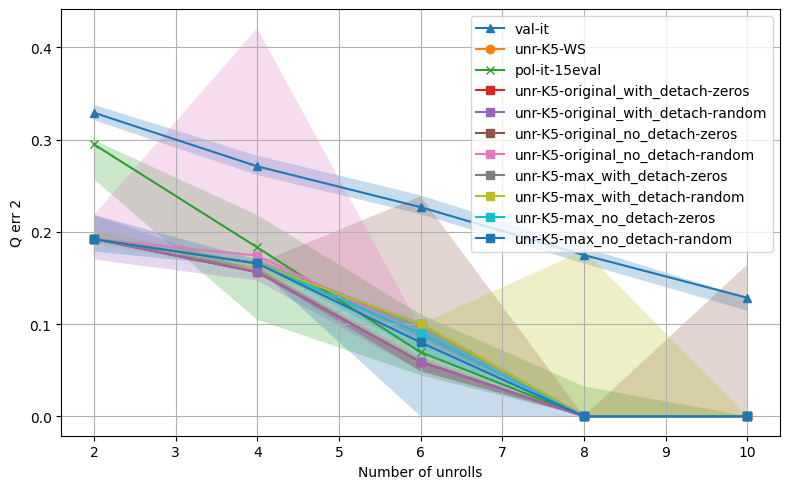

Data saved to csv file: results/n_unrolls/n_unrolls_all_data_with_new_experiments_med_err.csv
Data saved to csv file: results/n_unrolls/n_unrolls_all_data_with_new_experiments_prctile25.csv
Data saved to csv file: results/n_unrolls/n_unrolls_all_data_with_new_experiments_prctile75.csv


In [ ]:
# Select only specific indices: 0, 2, and 5, plus all new experiments
# First identify the indices of the new experiments (they start from index 12 onward)
original_experiments = 12  # K5(4) + K10(4) + K15(4) = 12 original experiments
new_experiment_start = original_experiments

# We want indices: 0, 2, 5 (from original) + all new experiments
selected_indices = [0, 2, 5]

# Add all new experiment indices  
if len(Exps) > original_experiments:
    selected_indices.extend(range(new_experiment_start, len(Exps)))

print(f"Selected experiment indices: {selected_indices}")
print("Selected experiments:")
for idx in selected_indices:
    if idx < len(Exps):
        print(f"{idx}: {Exps[idx]['name']}")

# Create skip_idx - all indices EXCEPT the selected ones
all_indices = set(range(len(Exps)))
selected_set = set(selected_indices)
skip_idx = list(all_indices - selected_set)

print(f"Skip indices: {skip_idx}")

xlabel = "Number of unrolls"
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')

if SAVE:
    file_name = PATH + "n_unrolls_all_data_with_new_experiments_med_err.csv"
    save_error_matrix_to_csv(np.median(errs2, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "n_unrolls_all_data_with_new_experiments_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 25, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "n_unrolls_all_data_with_new_experiments_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs2, 75, axis=0), N_unrolls, Exps, file_name)